In [14]:
# ============================================================
# 1️⃣ Set ZIP path (Give your own path here)
# ============================================================
zip_path = "/content/archive (25).zip"   # 🔴 Change this to your ZIP file path
extract_dir = "/content/dataset"


In [15]:
# ============================================================
# 2️⃣ Extract ZIP
# ============================================================
import zipfile, os

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("ZIP extracted successfully!")


ZIP extracted successfully!


In [16]:
# ============================================================
# 3️⃣ Auto-detect train/ and test/ folders
# ============================================================
train_dir = ""
test_dir = ""

for root, dirs, files in os.walk(extract_dir):
    if os.path.basename(root).lower() == "train":
        train_dir = root
    if os.path.basename(root).lower() == "test":
        test_dir = root

print("Train Folder:", train_dir)
print("Test Folder :", test_dir)

if train_dir == "" or test_dir == "":
    raise Exception("❌ Could not detect train/ or test/ folders.")


Train Folder: /content/dataset/Nutrition_dataset/train
Test Folder : /content/dataset/Nutrition_dataset/test


In [17]:
# ============================================================
# 4️⃣ Create Image Generators
# ============================================================
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True
).flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=True
)

test_gen = ImageDataGenerator(
    rescale=1./255
).flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)


Found 12795 images belonging to 6 classes.
Found 4832 images belonging to 6 classes.


In [18]:
# ============================================================
# 5️⃣ Build High Accuracy CNN (MobileNetV2)
# ============================================================
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze base model
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)

num_classes = train_gen.num_classes
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [19]:
# ============================================================
# 6️⃣ Compile Model
# ============================================================
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,587,462 (9.87 MB)

 Trainable params: 329,478 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [20]:
# ============================================================
# 7️⃣ Train Model
# ============================================================
history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=12
)


Epoch 1/12
400/400 ━━━━━━━━━━━━━━━━━━━━ 227s 485ms/step - accuracy: 0.6040 - loss: 1.1638 - val_accuracy: 0.7928 - val_loss: 0.5710
Epoch 2/12
400/400 ━━━━━━━━━━━━━━━━━━━━ 149s 373ms/step - accuracy: 0.7848 - loss: 0.6104 - val_accuracy: 0.8622 - val_loss: 0.4155
Epoch 3/12
400/400 ━━━━━━━━━━━━━━━━━━━━ 147s 367ms/step - accuracy: 0.8195 - loss: 0.5069 - val_accuracy: 0.8767 - val_loss: 0.3730
Epoch 4/12
400/400 ━━━━━━━━━━━━━━━━━━━━ 148s 371ms/step - accuracy: 0.8345 - loss: 0.4740 - val_accuracy: 0.8959 - val_loss: 0.3039
Epoch 5/12
400/400 ━━━━━━━━━━━━━━━━━━━━ 148s 368ms/step - accuracy: 0.8410 - loss: 0.4446 - val_accuracy: 0.8793 - val_loss: 0.3620
Epoch 6/12
400/400 ━━━━━━━━━━━━━━━━━━━━ 147s 367ms/step - accuracy: 0.8569 - loss: 0.4103 - val_accuracy: 0.8945 - val_loss: 0.3188
Epoch 7/12
400/400 ━━━━━━━━━━━━━━━━━━━━ 148s 369ms/step - accuracy: 0.8603 - loss: 0.3873 - val_accuracy: 0.9048 - val_loss: 0.2845
Epoch 8/12
400/400 ━━━━━━━━━━━━━━━━━━━━ 148s 369ms/step - accuracy: 0.8677 -

In [ ]:
# ============================================================
# 8️⃣ Evaluate Final Accuracy
# ============================================================
loss, acc = model.evaluate(test_gen)
print("\n🔥 Final Test Accuracy:", acc * 100, "%")

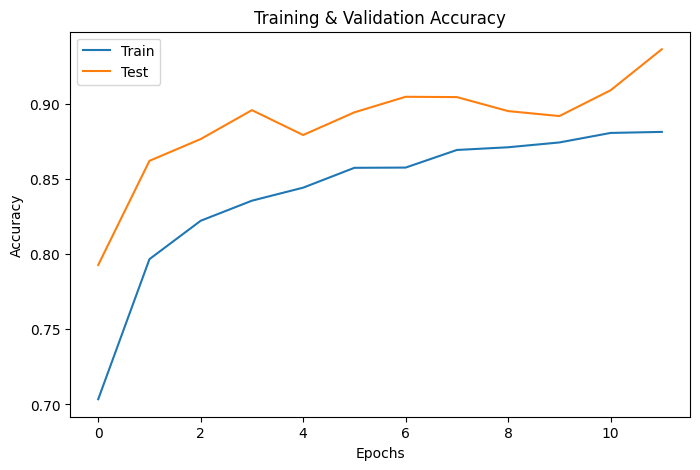

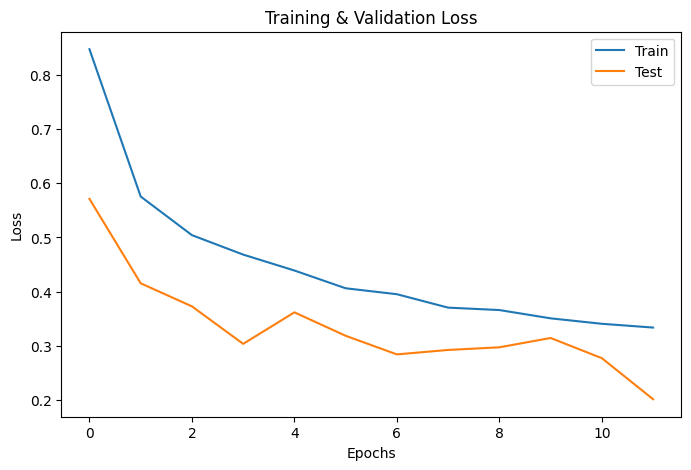

In [22]:
# ============================================================
# 8️⃣ Plot Accuracy & Loss Graphs
# ============================================================
import matplotlib.pyplot as plt

# Accuracy Graph
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Training & Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "Test"])
plt.show()

# Loss Graph
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train", "Test"])
plt.show()


151/151 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step


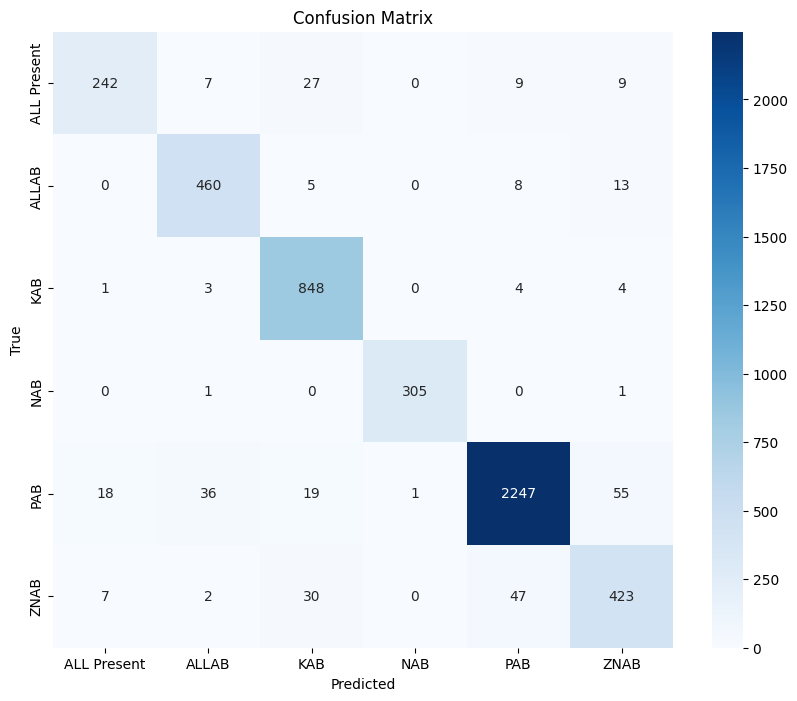

In [23]:
# ============================================================
# 9️⃣ Confusion Matrix (Heatmap)
# ============================================================
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# True & Predicted Labels
true_labels = test_gen.classes
pred_probs = model.predict(test_gen)
pred_labels = np.argmax(pred_probs, axis=1)

class_names = list(test_gen.class_indices.keys())

cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [24]:
# ============================================================
# 9️⃣ Classification Report & Confusion Matrix
# ============================================================
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Get true labels
true_labels = test_gen.classes

# Predict
pred = model.predict(test_gen)
pred_labels = np.argmax(pred, axis=1)

# Class names
class_labels = list(test_gen.class_indices.keys())

# Print Classification Report
print("\n📌 CLASSIFICATION REPORT")
print(classification_report(true_labels, pred_labels, target_names=class_labels))


151/151 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step

📌 CLASSIFICATION REPORT
              precision    recall  f1-score   support

 ALL Present       0.90      0.82      0.86       294
       ALLAB       0.90      0.95      0.92       486
         KAB       0.91      0.99      0.95       860
         NAB       1.00      0.99      1.00       307
         PAB       0.97      0.95      0.96      2376
        ZNAB       0.84      0.83      0.83       509

    accuracy                           0.94      4832
   macro avg       0.92      0.92      0.92      4832
weighted avg       0.94      0.94      0.94      4832



In [28]:
# ============================================================
# Training & Validation final scores
# ============================================================
train_acc = history.history['accuracy'][-1]
train_loss = history.history['loss'][-1]

val_acc = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]

print("============================================")
print(f"Final Training Accuracy      : {train_acc * 100:.2f}%")
print(f"Final Training Loss          : {train_loss:.4f}")
print(f"Final Validation Accuracy    : {val_acc * 100:.2f}%")
print(f"Final Validation Loss        : {val_loss:.4f}")
print("============================================")


Final Training Accuracy      : 88.14%
Final Training Loss          : 0.3339
Final Validation Accuracy    : 93.65%
Final Validation Loss        : 0.2019


In [25]:
model.save("best_mobilenet_model.h5")
print("Model saved successfully!")


Model saved successfully!


In [26]:
# ============================================================
# Predict on the entire test set
# ============================================================
import numpy as np
import pandas as pd

test_gen.reset()

pred_probs = model.predict(test_gen)
pred_labels = np.argmax(pred_probs, axis=1)
true_labels = test_gen.classes

class_names = list(test_gen.class_indices.keys())

# Convert to table
results_df = pd.DataFrame({
    "Filename": test_gen.filenames,
    "True Class": [class_names[i] for i in true_labels],
    "Predicted Class": [class_names[i] for i in pred_labels]
})

print("\n================== PREDICTIONS ==================")
print(results_df.head(20))   # Show first 20
print("\nTotal Predictions:", len(results_df))


151/151 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step

================== PREDICTIONS ==================
                  Filename   True Class Predicted Class
0   ALL Present/0412_0.jpg  ALL Present     ALL Present
1   ALL Present/0412_2.jpg  ALL Present     ALL Present
2   ALL Present/0416_0.jpg  ALL Present     ALL Present
3   ALL Present/0416_1.jpg  ALL Present     ALL Present
4   ALL Present/0418_0.jpg  ALL Present     ALL Present
5   ALL Present/0418_1.jpg  ALL Present     ALL Present
6   ALL Present/0419_2.jpg  ALL Present     ALL Present
7   ALL Present/0419_3.jpg  ALL Present     ALL Present
8   ALL Present/0420_4.jpg  ALL Present             KAB
9   ALL Present/0421_1.jpg  ALL Present     ALL Present
10  ALL Present/0421_2.jpg  ALL Present     ALL Present
11  ALL Present/0422_4.jpg  ALL Present           ALLAB
12  ALL Present/0424_0.jpg  ALL Present             KAB
13  ALL Present/0427_3.jpg  ALL Present     ALL Present
14  ALL Present/0428_3.jpg  ALL Present     ALL Present
15  ALL Pre

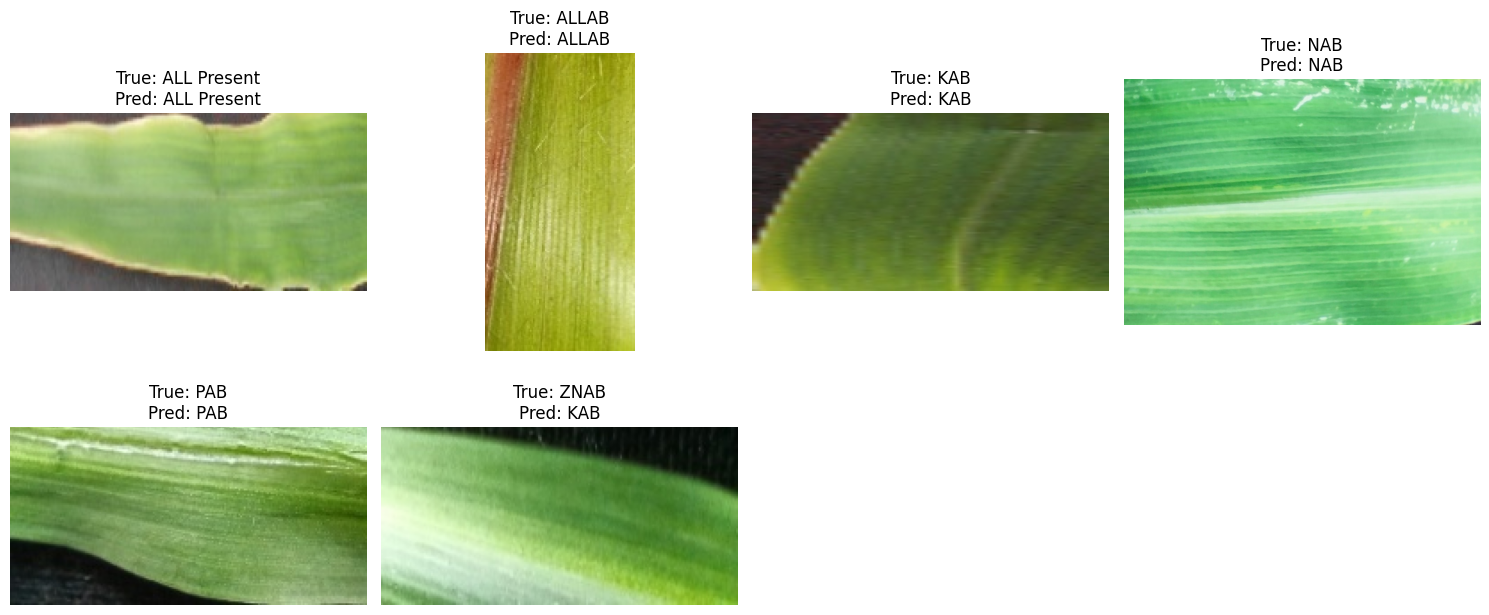

In [27]:
# ============================================================
# Show one prediction per class
# ============================================================
import matplotlib.pyplot as plt

shown_classes = set()

plt.figure(figsize=(15, 10))
plot_index = 1

for i in range(len(results_df)):
    row = results_df.iloc[i]
    true_c = row["True Class"]
    pred_c = row["Predicted Class"]

    if true_c not in shown_classes:
        img_path = test_dir + "/" + row["Filename"]
        img = plt.imread(img_path)

        plt.subplot(3, 4, plot_index)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"True: {true_c}\nPred: {pred_c}")

        shown_classes.add(true_c)
        plot_index += 1

    if len(shown_classes) == len(class_names):
        break

plt.tight_layout()
plt.show()


In [29]:
# ============================================================
# Prediction stats per class
# ============================================================
from collections import Counter

print("\nCorrect Predictions per Class:")
correct = Counter()

for t, p in zip(true_labels, pred_labels):
    if t == p:
        correct[class_names[t]] += 1

print(dict(correct))

print("\nTotal Images per Class:")
counts = Counter(true_labels)
print({class_names[k]: counts[k] for k in counts})



Correct Predictions per Class:
{'ALL Present': 242, 'ALLAB': 460, 'KAB': 848, 'NAB': 305, 'PAB': 2247, 'ZNAB': 423}

Total Images per Class:
{'ALL Present': 294, 'ALLAB': 486, 'KAB': 860, 'NAB': 307, 'PAB': 2376, 'ZNAB': 509}


In [30]:
import os

classes = sorted(os.listdir(train_dir))
classes


['ALL Present', 'ALLAB', 'KAB', 'NAB', 'PAB', 'ZNAB']

Using test image: /content/dataset/Nutrition_dataset/test/ZNAB/1098_3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

Predicted Class: PAB
Recommendation: Phosphorus deficiency borderline. Apply SSP (Single Super Phosphate), bone meal, or rock phosphate.



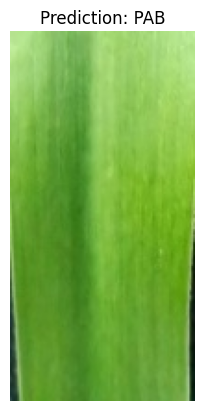

In [34]:
class_names = ['ALL Present', 'ALLAB', 'KAB', 'NAB', 'PAB', 'ZNAB']
recommendations = {
    "ALL Present": "Multiple nutrient deficiencies detected. Apply a balanced NPK + Zinc fertilizer and increase organic matter.",
    "ALLAB": "Nutrient levels are borderline. Apply mild NPK fertilizer and monitor leaf color for 10 days.",
    "KAB": "Potassium deficiency borderline. Apply Muriate of Potash (MOP) or organic sources like wood ash or banana peels.",
    "NAB": "Nitrogen deficiency borderline. Apply Urea, DAP, compost, or any nitrogen-rich organic manure.",
    "PAB": "Phosphorus deficiency borderline. Apply SSP (Single Super Phosphate), bone meal, or rock phosphate.",
    "ZNAB": "Zinc deficiency borderline. Apply Zinc Sulphate (ZnSO4) and maintain soil pH between 6.5 and 7.0."
}
import os
from tensorflow.keras.preprocessing import image
import numpy as np

test_dir = "/content/dataset/Nutrition_dataset/test"   # 🔹 change if your test folder is different

# Automatically find first test image
found_img = None

for cls in os.listdir(test_dir):
    cls_path = os.path.join(test_dir, cls)
    for img_name in os.listdir(cls_path):
        found_img = os.path.join(cls_path, img_name)
        break
    if found_img:
        break

print("Using test image:", found_img)

# Load and predict
img = image.load_img(found_img, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)
pred_class = np.argmax(pred)
predicted_label = class_names[pred_class]

print("\n==============================")
print("Predicted Class:", predicted_label)
print("Recommendation:", recommendations[predicted_label])
print("==============================\n")

import matplotlib.pyplot as plt

plt.imshow(image.load_img(found_img))
plt.title(f"Prediction: {predicted_label}")
plt.axis("off")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


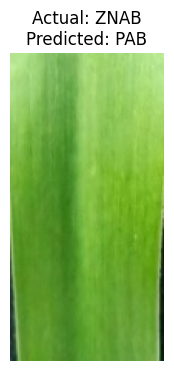

Image: 1098_3.jpg
Actual Class: ZNAB
Predicted Class: PAB
Recommendation: Phosphorus deficiency borderline. Apply SSP (Single Super Phosphate), bone meal, or rock phosphate.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


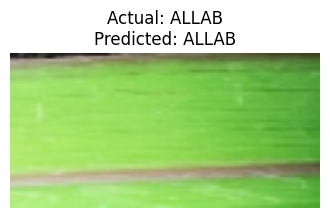

Image: 1327_0.jpg
Actual Class: ALLAB
Predicted Class: ALLAB
Recommendation: Nutrient levels are borderline. Apply mild NPK fertilizer and monitor leaf color for 10 days.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


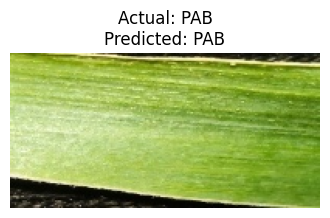

Image: 1327_0.jpg
Actual Class: PAB
Predicted Class: PAB
Recommendation: Phosphorus deficiency borderline. Apply SSP (Single Super Phosphate), bone meal, or rock phosphate.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


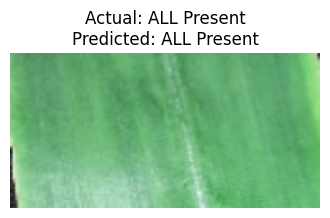

Image: 0654_1.jpg
Actual Class: ALL Present
Predicted Class: ALL Present
Recommendation: Multiple nutrient deficiencies detected. Apply a balanced NPK + Zinc fertilizer and increase organic matter.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


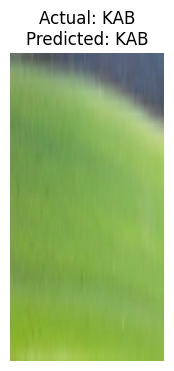

Image: 0596_0_3.jpg
Actual Class: KAB
Predicted Class: KAB
Recommendation: Potassium deficiency borderline. Apply Muriate of Potash (MOP) or organic sources like wood ash or banana peels.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


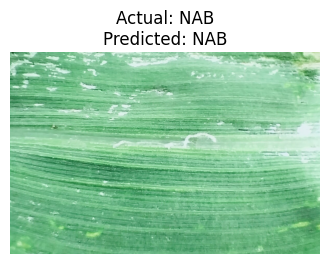

Image: IMG20230319161659_01.jpg
Actual Class: NAB
Predicted Class: NAB
Recommendation: Nitrogen deficiency borderline. Apply Urea, DAP, compost, or any nitrogen-rich organic manure.



In [36]:
test_dir = "/content/dataset/Nutrition_dataset/test"

# Loop through classes
for cls in os.listdir(test_dir):
    cls_path = os.path.join(test_dir, cls)
    if not os.path.isdir(cls_path):
        continue

    # Get first image in the class folder
    img_name = os.listdir(cls_path)[0]
    img_path = os.path.join(cls_path, img_name)

    # Load image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    pred = model.predict(img_array)
    pred_class = np.argmax(pred)
    predicted_label = class_names[pred_class]

    # Display image
    plt.figure(figsize=(4, 4))
    plt.imshow(image.load_img(img_path))
    plt.title(f"Actual: {cls}\nPredicted: {predicted_label}")
    plt.axis("off")
    plt.show()

    # Print recommendation
    print("==============================================")
    print("Image:", img_name)
    print("Actual Class:", cls)
    print("Predicted Class:", predicted_label)
    print("Recommendation:", recommendations[predicted_label])
    print("==============================================\n")